In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv


In [2]:
import pandas as pd

# Load the compressed CSV directly
df = pd.read_csv('/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz')

# Check the first few rows
print(df.head())


/tmp/ipykernel_37/3871360836.py:4: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz')


         id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   
3  66310712        NaN    35000.0      35000.0          35000.0   60 months   
4  68476807        NaN    10400.0      10400.0          10400.0   60 months   

   int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount  \
0     13.99       123.03     C        C4  ...                            NaN   
1     11.99       820.28     C        C1  ...                            NaN   
2     10.78       432.66     B        B4  ...                            NaN   
3     14.85       829.90     C        C5  ...                            NaN   
4     22.45       289.91     F        F1  ...                            NaN   

  hardship_last_payment_amount disbursement_

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [3]:
SAMPLE_FRAC = 0.10   # set to None or 1.0 to use full data; 0.1 = use 10% for faster iteration
RANDOM_STATE = 42

In [4]:
if SAMPLE_FRAC is not None and 0 < SAMPLE_FRAC < 1:
    df = df.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE).reset_index(drop=True)
    print(f"Using sampled fraction {SAMPLE_FRAC}; shape ->", df.shape)
else:
    print("Using full dataset; shape ->", df.shape)


Using sampled fraction 0.1; shape -> (226070, 151)


In [6]:
print("\nColumns:", len(df.columns))
print(df.columns.tolist()[:40]) 

print("\nloan_status value counts:")
print(df['loan_status'].value_counts(dropna=False).head(40))

missing = df.isna().mean().sort_values(ascending=False)
print("\nTop 30 columns by % missing:")
print(missing.head(30))



Columns: 151
['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv']

loan_status value counts:
loan_status
Fully Paid                                             107427
Current                                                 87960
Charged Off                                             26875
Late (31-120 days)                                       2256
In Grace Period                                           850
Late (16-30 days)                                         451
Doe

In [8]:

if 'term' in df.columns:
    df['term'] = df['term'].astype(str).str.extract(r'(\d+)').astype(float)

if 'int_rate' in df.columns:
    df['int_rate'] = df['int_rate'].astype(str).str.replace('%','').replace('nan','',regex=False)
    df.loc[df['int_rate']=='', 'int_rate'] = np.nan
    df['int_rate'] = pd.to_numeric(df['int_rate'], errors='coerce')

if 'emp_length' in df.columns:
    df['emp_length'] = df['emp_length'].astype(str).replace(['n/a','nan','None'],'0', regex=False)
    df['emp_length'] = df['emp_length'].str.replace(r'\+','',regex=True)
    df['emp_length'] = df['emp_length'].str.replace(r'([<> ]+years?)','',regex=True).str.replace('year','',regex=False).str.strip()
    # possible leftovers like '< 1' -> '1' after replacing '<' etc; use to_numeric
    df['emp_length'] = pd.to_numeric(df['emp_length'], errors='coerce').fillna(0)

In [9]:
if 'fico_range_low' in df.columns and 'fico_range_high' in df.columns:
    df['fico_mean'] = df[['fico_range_low','fico_range_high']].mean(axis=1)

if 'revol_util' in df.columns:
    df['revol_util'] = df['revol_util'].astype(str).str.replace('%','').replace('nan','',regex=False)
    df.loc[df['revol_util']=='', 'revol_util'] = np.nan
    df['revol_util'] = pd.to_numeric(df['revol_util'], errors='coerce')

In [10]:
def map_status(s):
    s = str(s).lower()
    if 'fully paid' in s:
        return 0
    if 'charged off' in s or 'default' in s:
        return 1
    # treat other closed states as NaN (or you can map late/collections to 1 depending on policy)
    return np.nan

df['target'] = df['loan_status'].apply(map_status)

print("\nAfter mapping, target value counts:")
print(df['target'].value_counts(dropna=False))

# Drop rows with unknown target
df = df.dropna(subset=['target']).reset_index(drop=True)
df['target'] = df['target'].astype(int)
print("After dropping unknown-target rows:", df.shape)



After mapping, target value counts:
target
0.0    107600
NaN     91521
1.0     26949
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


After dropping unknown-target rows: (134549, 153)


In [11]:
features = [
    'loan_amnt', 'term', 'int_rate', 'installment',
    'grade', 'sub_grade', 'emp_length', 'home_ownership',
    'annual_inc', 'verification_status', 'purpose',
    'dti', 'delinq_2yrs', 'fico_mean', 'inq_last_6mths',
    'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc'
]
use_feats = [c for c in features if c in df.columns]
print("\nUsing features:", use_feats)

data = df[use_feats + ['target']].copy()

print("\nSelected features missing %:")
print(data.isna().mean().sort_values(ascending=False))

num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in use_feats if c not in num_cols]
print("\nNumeric cols:", num_cols)
print("Categorical cols (to encode):", cat_cols)


Using features: ['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'dti', 'delinq_2yrs', 'fico_mean', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc']

Selected features missing %:
revol_util             0.000587
dti                    0.000268
int_rate               0.000000
term                   0.000000
loan_amnt              0.000000
grade                  0.000000
installment            0.000000
home_ownership         0.000000
sub_grade              0.000000
annual_inc             0.000000
verification_status    0.000000
purpose                0.000000
emp_length             0.000000
delinq_2yrs            0.000000
fico_mean              0.000000
open_acc               0.000000
inq_last_6mths         0.000000
pub_rec                0.000000
revol_bal              0.000000
total_acc              0.000000
target                 0.000000
dtype: float64

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# split features into numeric and categorical
numeric_features = [c for c in num_cols if c != 'target']
categorical_features = cat_cols

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)


In [13]:
X = preprocessor.fit_transform(data.drop(columns=['target']))
y = data['target'].values

print("\nPreprocessed X shape:", X.shape, "y shape:", y.shape)


Preprocessed X shape: (134549, 80) y shape: (134549,)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
from sklearn.model_selection import train_test_split

data_out_path = "/kaggle/working/lc_processed_sample.csv"
data.to_csv(data_out_path, index=False)
print("Saved selected raw columns to", data_out_path)

# Train / test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
print("Train/test shapes:", X_train.shape, X_test.shape, y_train.sum(), "/", y_test.sum())

Saved selected raw columns to /kaggle/working/lc_processed_sample.csv
Train/test shapes: (107639, 80) (26910, 80) 21559 / 5390


In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define model
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

2025-10-25 13:52:56.780436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761400377.014531      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761400377.081005      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1761400390.217328      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761400390.217995      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,689 (73.00 KB)

 Trainable params: 18,689 (73.00 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='AUC')]
)

In [19]:
es = callbacks.EarlyStopping(monitor='val_AUC', patience=3, mode='max', restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=512,
    callbacks=[es],
    verbose=1
)

Epoch 1/20


I0000 00:00:1761400446.040514     136 service.cc:148] XLA service 0x7f6fa40049b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761400446.041230     136 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761400446.041249     136 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761400446.322742     136 cuda_dnn.cc:529] Loaded cuDNN version 90300


 71/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.5699 - loss: 0.5328

I0000 00:00:1761400448.080213     136 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - AUC: 0.6178 - loss: 0.5033 - val_AUC: 0.7098 - val_loss: 0.4578
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6974 - loss: 0.4611 - val_AUC: 0.7111 - val_loss: 0.4558
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7052 - loss: 0.4581 - val_AUC: 0.7133 - val_loss: 0.4544
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7081 - loss: 0.4562 - val_AUC: 0.7144 - val_loss: 0.4535
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7151 - loss: 0.4517 - val_AUC: 0.7141 - val_loss: 0.4559
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7088 - loss: 0.4548 - val_AUC: 0.7148 - val_loss: 0.4531
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7121 - loss: 0.4524 - val_AUC: 0.7152 - val_loss: 0.4531
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7141 - loss: 0.4507 - val_AUC: 0.7153 - val_loss: 0.4532
Epoch 9/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7137 

841/841 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Test AUC: 0.7077
Test F1-Score: 0.4268


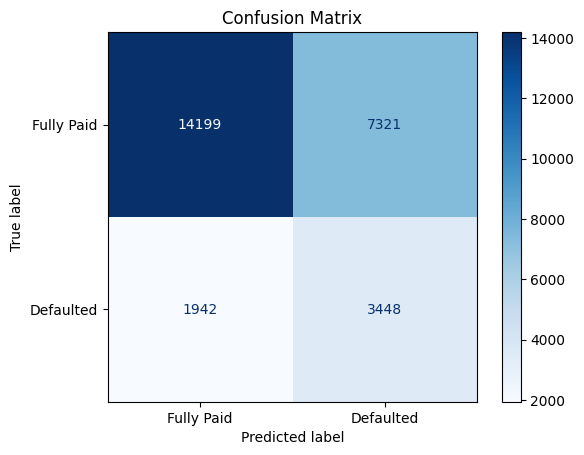

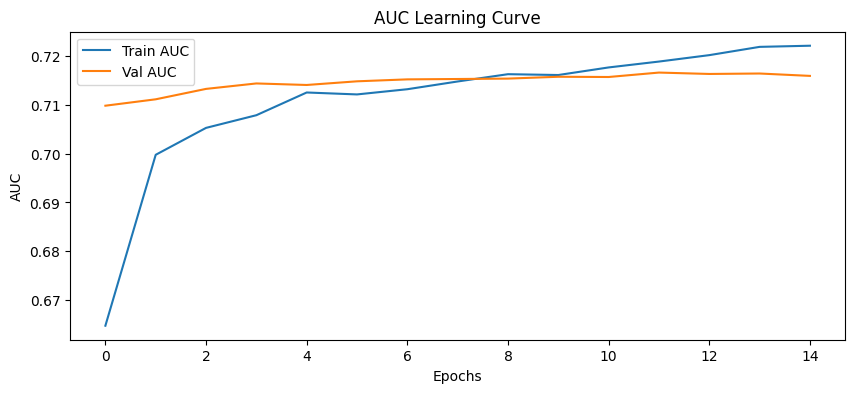

In [22]:
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)

auc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred_labels)
print(f"\nTest AUC: {auc:.4f}")
print(f"Test F1-Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)
ConfusionMatrixDisplay(cm, display_labels=["Fully Paid", "Defaulted"]).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Plot training curves
plt.figure(figsize=(10,4))
plt.plot(history.history['AUC'], label='Train AUC')
plt.plot(history.history['val_AUC'], label='Val AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.title("AUC Learning Curve")
plt.show()

In [21]:
from sklearn.utils import class_weight
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw = dict(enumerate(cw))

model.fit(X_train, y_train, validation_split=0.2, epochs=20,
          batch_size=512, callbacks=[es], verbose=1, class_weight=cw)


Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - AUC: 0.6911 - loss: 0.6532 - val_AUC: 0.7159 - val_loss: 0.5989
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7208 - loss: 0.6128 - val_AUC: 0.7171 - val_loss: 0.6124
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7264 - loss: 0.6082 - val_AUC: 0.7167 - val_loss: 0.6029
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7236 - loss: 0.6110 - val_AUC: 0.7158 - val_loss: 0.6217
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7264 - loss: 0.6116 - val_AUC: 0.7166 - val_loss: 0.5932


In [45]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

y_true = outcomes_test
y_pred_prob = model.predict(obs_test).reshape(-1)
threshold = best_thresh if 'best_thresh' in globals() else 0.5
y_pred = (y_pred_prob < threshold).astype(int)

auc = roc_auc_score(y_true, y_pred_prob)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("AUC:", auc)
print("F1-Score:", f1)
print("Confusion Matrix:\n", cm)


841/841 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
AUC: 0.7077019392582987
F1-Score: 0.18039106404718777
Confusion Matrix:
 [[ 7321 14199]
 [ 3448  1942]]


In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# d3rlpy imports
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import DiscreteCQL


import tensorflow as tf

def make_rewards(loan_amnt_arr, int_rate_arr, outcomes, actions):
    """
    loan_amnt_arr, int_rate_arr: arrays aligned with observations
    outcomes: 0 (fully paid) or 1 (defaulted) for each row (ground truth)
    actions: 0 or 1 array
    Returns array of rewards per row.
    """
    int_frac = np.array(int_rate_arr, dtype=np.float32) / 100.0
    loan_amnt = np.array(loan_amnt_arr, dtype=np.float32)
    outcomes = np.array(outcomes, dtype=np.int32)
    actions = np.array(actions, dtype=np.int32)
    rewards = np.zeros_like(actions, dtype=np.float32)

    approve_and_paid = (actions == 1) & (outcomes == 0)
    rewards[approve_and_paid] = loan_amnt[approve_and_paid] * int_frac[approve_and_paid]
    approve_and_default = (actions == 1) & (outcomes == 1)
    rewards[approve_and_default] = - loan_amnt[approve_and_default]

    return rewards


In [30]:
processed_df = pd.read_csv("/kaggle/working/lc_processed_sample.csv")  # saved earlier

train_df, test_df = train_test_split(processed_df, test_size=0.20, random_state=42, stratify=processed_df['target'])

try:
    X_train = preprocessor.transform(train_df.drop(columns=['target']))
    X_test  = preprocessor.transform(test_df.drop(columns=['target']))
except Exception as e:
    print("Preprocessor missing in kernel session; creating quick numeric array from numeric columns.")
    # fallback: use numeric columns only (simple)
    num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c != 'target']
    X_train = train_df[num_cols].fillna(0).values
    X_test  = test_df[num_cols].fillna(0).values

obs_train = X_train.astype('float32')
obs_test  = X_test.astype('float32')

outcomes_train = train_df['target'].values.astype(int)
outcomes_test  = test_df['target'].values.astype(int)

loan_amnt_train = train_df['loan_amnt'].values
loan_amnt_test  = test_df['loan_amnt'].values
int_rate_train  = train_df['int_rate'].values
int_rate_test   = test_df['int_rate'].values

actions_logged_train = np.ones((obs_train.shape[0],), dtype=int)
rewards_logged_train = make_rewards(loan_amnt_train, int_rate_train, outcomes_train, actions_logged_train)
terminals_train = np.ones_like(rewards_logged_train, dtype=bool)  # one-step episodes

obs_train_aug = np.concatenate([obs_train, obs_train], axis=0)
actions_train_aug = np.concatenate([actions_logged_train, np.zeros_like(actions_logged_train)], axis=0)
rewards_train_aug = np.concatenate([rewards_logged_train, np.zeros_like(rewards_logged_train)], axis=0)
terminals_train_aug = np.concatenate([terminals_train, np.ones_like(terminals_train)], axis=0)

print("Original train size:", obs_train.shape[0])
print("Augmented train size:", obs_train_aug.shape[0])


Original train size: 107639
Augmented train size: 215278


In [40]:
# %%
# RL Training for LendingClub Dataset (Latest d3rlpy v2.x API)

from d3rlpy.algos import DiscreteCQLConfig
from d3rlpy.dataset import MDPDataset

# Prepare your dataset
# For discrete actions, actions should be integers in 1D array
# rewards and terminals should also be 1D arrays
dataset = MDPDataset(
    observations=obs_train_aug,
    actions=actions_train_aug,  # Should be 1D integer array
    rewards=rewards_train_aug,   # Should be 1D float array
    terminals=terminals_train_aug # Should be 1D float array (0s and 1s)
)

# Create CQL config
config = DiscreteCQLConfig(
    learning_rate=1e-4,
    batch_size=256,
)

# Create CQL agent
cql = config.create(device="cuda:0")

# Calculate n_steps using transition_count
n_epochs = 50
n_steps = n_epochs * (dataset.transition_count // 256)

cql.fit(
    dataset,
    n_steps=n_steps,
    n_steps_per_epoch=dataset.transition_count // 256,
    show_progress=True,
)


2025-10-25 14:35.07 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(80,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2025-10-25 14:35.07 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-10-25 14:35.07 [info     ] Action size has been automatically determined. action_size=2
2025-10-25 14:35.08 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(80,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-10-25 14:35.08 [debug    ] Building models...            
2025-10-25 14:35.08 [debug    ] Models have been built.       
2025-10-25 14:35.08 [info  

Epoch 1/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:35.17 [info     ] DiscreteCQL_20251025143508: epoch=1 step=840 epoch=1 metrics={'time_sample_batch': 0.004837210689272199, 'time_algorithm_update': 0.005464369342440651, 'loss': 2319.1120602562314, 'td_loss': 2318.139541335333, 'conservative_loss': 0.9725163442747934, 'time_step': 0.010368229945500691} step=840
2025-10-25 14:35.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_840.d3


Epoch 2/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:35.25 [info     ] DiscreteCQL_20251025143508: epoch=2 step=1680 epoch=2 metrics={'time_sample_batch': 0.004820979493004935, 'time_algorithm_update': 0.004657823698861258, 'loss': 2313.3122424897692, 'td_loss': 2312.2856565929596, 'conservative_loss': 1.026587976657209, 'time_step': 0.009535418237958636} step=1680
2025-10-25 14:35.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_1680.d3


Epoch 3/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:35.33 [info     ] DiscreteCQL_20251025143508: epoch=3 step=2520 epoch=3 metrics={'time_sample_batch': 0.004785215286981492, 'time_algorithm_update': 0.00459980396997361, 'loss': 2291.273712884812, 'td_loss': 2290.247444225493, 'conservative_loss': 1.0262691326084592, 'time_step': 0.009441513958431425} step=2520
2025-10-25 14:35.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_2520.d3


Epoch 4/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:35.41 [info     ] DiscreteCQL_20251025143508: epoch=4 step=3360 epoch=4 metrics={'time_sample_batch': 0.004798511096409389, 'time_algorithm_update': 0.004583487908045451, 'loss': 2301.494292922247, 'td_loss': 2300.4589569091795, 'conservative_loss': 1.0353401369991757, 'time_step': 0.009438991830462502} step=3360
2025-10-25 14:35.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_3360.d3


Epoch 5/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:35.49 [info     ] DiscreteCQL_20251025143508: epoch=5 step=4200 epoch=5 metrics={'time_sample_batch': 0.004780804259436471, 'time_algorithm_update': 0.004588307085491362, 'loss': 2283.085522315616, 'td_loss': 2282.052606782459, 'conservative_loss': 1.0329147458786057, 'time_step': 0.00942648280234564} step=4200
2025-10-25 14:35.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_4200.d3


Epoch 6/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:35.57 [info     ] DiscreteCQL_20251025143508: epoch=6 step=5040 epoch=6 metrics={'time_sample_batch': 0.004784942524773734, 'time_algorithm_update': 0.0045703450838724775, 'loss': 2315.4159513927643, 'td_loss': 2314.3743693033853, 'conservative_loss': 1.0415818704735664, 'time_step': 0.009412386020024617} step=5040
2025-10-25 14:35.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_5040.d3


Epoch 7/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:36.05 [info     ] DiscreteCQL_20251025143508: epoch=7 step=5880 epoch=7 metrics={'time_sample_batch': 0.004921434039161319, 'time_algorithm_update': 0.00472160435858227, 'loss': 2303.166463797433, 'td_loss': 2302.1202285039994, 'conservative_loss': 1.0462279328278132, 'time_step': 0.009700514589037213} step=5880
2025-10-25 14:36.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_5880.d3


Epoch 8/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:36.14 [info     ] DiscreteCQL_20251025143508: epoch=8 step=6720 epoch=8 metrics={'time_sample_batch': 0.00516628935223534, 'time_algorithm_update': 0.004852154425212315, 'loss': 2289.088207717169, 'td_loss': 2288.0478506905692, 'conservative_loss': 1.0403551667928697, 'time_step': 0.010082989647274925} step=6720
2025-10-25 14:36.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_6720.d3


Epoch 9/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:36.22 [info     ] DiscreteCQL_20251025143508: epoch=9 step=7560 epoch=9 metrics={'time_sample_batch': 0.00516791201773144, 'time_algorithm_update': 0.004865969646544684, 'loss': 2298.4406005859373, 'td_loss': 2297.400484502883, 'conservative_loss': 1.040114180176031, 'time_step': 0.010099135410218011} step=7560
2025-10-25 14:36.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_7560.d3


Epoch 10/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:36.31 [info     ] DiscreteCQL_20251025143508: epoch=10 step=8400 epoch=10 metrics={'time_sample_batch': 0.0051301340262095135, 'time_algorithm_update': 0.004810864584786551, 'loss': 2298.578860764276, 'td_loss': 2297.5398409888858, 'conservative_loss': 1.0390134409779594, 'time_step': 0.010006108170463926} step=8400
2025-10-25 14:36.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_8400.d3


Epoch 11/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:36.39 [info     ] DiscreteCQL_20251025143508: epoch=11 step=9240 epoch=11 metrics={'time_sample_batch': 0.00494325388045538, 'time_algorithm_update': 0.004713737964630127, 'loss': 2300.215629359654, 'td_loss': 2299.1634878976006, 'conservative_loss': 1.0521409856421606, 'time_step': 0.009717318841389247} step=9240
2025-10-25 14:36.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_9240.d3


Epoch 12/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:36.47 [info     ] DiscreteCQL_20251025143508: epoch=12 step=10080 epoch=12 metrics={'time_sample_batch': 0.004733787547974359, 'time_algorithm_update': 0.00453724463780721, 'loss': 2304.087543015253, 'td_loss': 2303.032025437128, 'conservative_loss': 1.0555190530561265, 'time_step': 0.009325521616708665} step=10080
2025-10-25 14:36.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_10080.d3


Epoch 13/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:36.55 [info     ] DiscreteCQL_20251025143508: epoch=13 step=10920 epoch=13 metrics={'time_sample_batch': 0.004762186322893415, 'time_algorithm_update': 0.004586211840311686, 'loss': 2316.0998811267673, 'td_loss': 2315.0592240106494, 'conservative_loss': 1.0406558053834098, 'time_step': 0.009402875673203241} step=10920
2025-10-25 14:36.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_10920.d3


Epoch 14/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:37.03 [info     ] DiscreteCQL_20251025143508: epoch=14 step=11760 epoch=14 metrics={'time_sample_batch': 0.004785278297605969, 'time_algorithm_update': 0.004568099407922654, 'loss': 2309.1140008835564, 'td_loss': 2308.0682698567707, 'conservative_loss': 1.0457348768909773, 'time_step': 0.009409709771474203} step=11760
2025-10-25 14:37.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_11760.d3


Epoch 15/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:37.11 [info     ] DiscreteCQL_20251025143508: epoch=15 step=12600 epoch=15 metrics={'time_sample_batch': 0.00477252517427717, 'time_algorithm_update': 0.004576692694709414, 'loss': 2298.56992347354, 'td_loss': 2297.5238568987165, 'conservative_loss': 1.0460653803178241, 'time_step': 0.009405072813942318} step=12600
2025-10-25 14:37.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_12600.d3


Epoch 16/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:37.19 [info     ] DiscreteCQL_20251025143508: epoch=16 step=13440 epoch=16 metrics={'time_sample_batch': 0.004734686158952259, 'time_algorithm_update': 0.004542540652411325, 'loss': 2282.621965244838, 'td_loss': 2281.564032709031, 'conservative_loss': 1.0579333489849454, 'time_step': 0.009331362588065011} step=13440
2025-10-25 14:37.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_13440.d3


Epoch 17/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:37.27 [info     ] DiscreteCQL_20251025143508: epoch=17 step=14280 epoch=17 metrics={'time_sample_batch': 0.0047531173342750185, 'time_algorithm_update': 0.004597190164384388, 'loss': 2290.39211890811, 'td_loss': 2289.3556162516275, 'conservative_loss': 1.0364987650087902, 'time_step': 0.009404037963776361} step=14280
2025-10-25 14:37.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_14280.d3


Epoch 18/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:37.35 [info     ] DiscreteCQL_20251025143508: epoch=18 step=15120 epoch=18 metrics={'time_sample_batch': 0.004717267411095755, 'time_algorithm_update': 0.004556548595428467, 'loss': 2278.295413062686, 'td_loss': 2277.245928373791, 'conservative_loss': 1.0494823672941753, 'time_step': 0.009325538930438814} step=15120
2025-10-25 14:37.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_15120.d3


Epoch 19/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:37.43 [info     ] DiscreteCQL_20251025143508: epoch=19 step=15960 epoch=19 metrics={'time_sample_batch': 0.0047655057339441205, 'time_algorithm_update': 0.00454868787810916, 'loss': 2309.5733261835007, 'td_loss': 2308.5293090820314, 'conservative_loss': 1.0440192548292024, 'time_step': 0.009368822688148135} step=15960
2025-10-25 14:37.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_15960.d3


Epoch 20/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:37.51 [info     ] DiscreteCQL_20251025143508: epoch=20 step=16800 epoch=20 metrics={'time_sample_batch': 0.004801883583977109, 'time_algorithm_update': 0.004578931274868193, 'loss': 2304.622065807524, 'td_loss': 2303.579524012974, 'conservative_loss': 1.0425450903319178, 'time_step': 0.009436440751666114} step=16800
2025-10-25 14:37.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_16800.d3


Epoch 21/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:37.59 [info     ] DiscreteCQL_20251025143508: epoch=21 step=17640 epoch=21 metrics={'time_sample_batch': 0.004818025089445568, 'time_algorithm_update': 0.004590423618044172, 'loss': 2287.8935118175687, 'td_loss': 2286.8555276053294, 'conservative_loss': 1.0379866657512529, 'time_step': 0.009463393120538621} step=17640
2025-10-25 14:37.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_17640.d3


Epoch 22/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:38.06 [info     ] DiscreteCQL_20251025143508: epoch=22 step=18480 epoch=22 metrics={'time_sample_batch': 0.004755172275361561, 'time_algorithm_update': 0.00454132528532119, 'loss': 2305.9967606317427, 'td_loss': 2304.9296011788506, 'conservative_loss': 1.0671593580217589, 'time_step': 0.00935143516177223} step=18480
2025-10-25 14:38.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_18480.d3


Epoch 23/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:38.14 [info     ] DiscreteCQL_20251025143508: epoch=23 step=19320 epoch=23 metrics={'time_sample_batch': 0.0047652769656408404, 'time_algorithm_update': 0.0045858175981612435, 'loss': 2288.446355474563, 'td_loss': 2287.3720684233167, 'conservative_loss': 1.0742892313571204, 'time_step': 0.009405984765007383} step=19320
2025-10-25 14:38.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_19320.d3


Epoch 24/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:38.22 [info     ] DiscreteCQL_20251025143508: epoch=24 step=20160 epoch=24 metrics={'time_sample_batch': 0.004807026329494658, 'time_algorithm_update': 0.0045849916480836415, 'loss': 2298.8797281901043, 'td_loss': 2297.8213977632067, 'conservative_loss': 1.0583317144995643, 'time_step': 0.009448657717023577} step=20160
2025-10-25 14:38.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_20160.d3


Epoch 25/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:38.30 [info     ] DiscreteCQL_20251025143508: epoch=25 step=21000 epoch=25 metrics={'time_sample_batch': 0.004799823817752656, 'time_algorithm_update': 0.004626157737913586, 'loss': 2300.5990594773066, 'td_loss': 2299.5413870675225, 'conservative_loss': 1.0576717446247736, 'time_step': 0.009480584803081693} step=21000
2025-10-25 14:38.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_21000.d3


Epoch 26/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:38.38 [info     ] DiscreteCQL_20251025143508: epoch=26 step=21840 epoch=26 metrics={'time_sample_batch': 0.004766240857896351, 'time_algorithm_update': 0.004572237105596633, 'loss': 2297.8962671189083, 'td_loss': 2296.8530619303388, 'conservative_loss': 1.0432038748548145, 'time_step': 0.009395812522797357} step=21840
2025-10-25 14:38.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_21840.d3


Epoch 27/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:38.46 [info     ] DiscreteCQL_20251025143508: epoch=27 step=22680 epoch=27 metrics={'time_sample_batch': 0.004737506593976702, 'time_algorithm_update': 0.004550604877017793, 'loss': 2312.1090584891185, 'td_loss': 2311.062001691546, 'conservative_loss': 1.0470591641607738, 'time_step': 0.009342238448915028} step=22680
2025-10-25 14:38.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_22680.d3


Epoch 28/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:38.54 [info     ] DiscreteCQL_20251025143508: epoch=28 step=23520 epoch=28 metrics={'time_sample_batch': 0.004755405301139468, 'time_algorithm_update': 0.004584142707643055, 'loss': 2312.704276529948, 'td_loss': 2311.6443288167316, 'conservative_loss': 1.0599493561756044, 'time_step': 0.009394905680701846} step=23520
2025-10-25 14:38.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_23520.d3


Epoch 29/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:39.02 [info     ] DiscreteCQL_20251025143508: epoch=29 step=24360 epoch=29 metrics={'time_sample_batch': 0.004755532457714989, 'time_algorithm_update': 0.004564285845983596, 'loss': 2317.0720576695035, 'td_loss': 2316.0210875011626, 'conservative_loss': 1.0509680582653909, 'time_step': 0.009374327886672248} step=24360
2025-10-25 14:39.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_24360.d3


Epoch 30/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:39.10 [info     ] DiscreteCQL_20251025143508: epoch=30 step=25200 epoch=30 metrics={'time_sample_batch': 0.00475511181922186, 'time_algorithm_update': 0.004563341538111369, 'loss': 2271.300822666713, 'td_loss': 2270.2482279459637, 'conservative_loss': 1.0525944382661865, 'time_step': 0.009373994100661505} step=25200
2025-10-25 14:39.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_25200.d3


Epoch 31/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:39.18 [info     ] DiscreteCQL_20251025143508: epoch=31 step=26040 epoch=31 metrics={'time_sample_batch': 0.004844725699651809, 'time_algorithm_update': 0.004614482607160296, 'loss': 2300.20690293085, 'td_loss': 2299.151732381185, 'conservative_loss': 1.0551712988387971, 'time_step': 0.009516094128290813} step=26040
2025-10-25 14:39.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_26040.d3


Epoch 32/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:39.26 [info     ] DiscreteCQL_20251025143508: epoch=32 step=26880 epoch=32 metrics={'time_sample_batch': 0.004767025084722609, 'time_algorithm_update': 0.004603652159372965, 'loss': 2276.011388142904, 'td_loss': 2274.9612046014695, 'conservative_loss': 1.0501850259445962, 'time_step': 0.009423576366333734} step=26880
2025-10-25 14:39.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_26880.d3


Epoch 33/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:39.34 [info     ] DiscreteCQL_20251025143508: epoch=33 step=27720 epoch=33 metrics={'time_sample_batch': 0.00480233147030785, 'time_algorithm_update': 0.004589542604628063, 'loss': 2319.7413138253346, 'td_loss': 2318.6799583798365, 'conservative_loss': 1.06135735334385, 'time_step': 0.009446911584763299} step=27720
2025-10-25 14:39.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_27720.d3


Epoch 34/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:39.42 [info     ] DiscreteCQL_20251025143508: epoch=34 step=28560 epoch=34 metrics={'time_sample_batch': 0.004806296598343622, 'time_algorithm_update': 0.004577632745107015, 'loss': 2311.8094553629558, 'td_loss': 2310.7511839367094, 'conservative_loss': 1.0582736328953788, 'time_step': 0.009439636695952642} step=28560
2025-10-25 14:39.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_28560.d3


Epoch 35/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:39.50 [info     ] DiscreteCQL_20251025143508: epoch=35 step=29400 epoch=35 metrics={'time_sample_batch': 0.004776713677815028, 'time_algorithm_update': 0.004567430700574603, 'loss': 2298.861702764602, 'td_loss': 2297.809191167922, 'conservative_loss': 1.0525120134154955, 'time_step': 0.009400104341052828} step=29400
2025-10-25 14:39.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_29400.d3


Epoch 36/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:39.58 [info     ] DiscreteCQL_20251025143508: epoch=36 step=30240 epoch=36 metrics={'time_sample_batch': 0.004738105478740874, 'time_algorithm_update': 0.004550275348481678, 'loss': 2309.9378176734563, 'td_loss': 2308.869193231492, 'conservative_loss': 1.068624042400292, 'time_step': 0.009341639280319215} step=30240
2025-10-25 14:39.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_30240.d3


Epoch 37/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:40.06 [info     ] DiscreteCQL_20251025143508: epoch=37 step=31080 epoch=37 metrics={'time_sample_batch': 0.004746506043842861, 'time_algorithm_update': 0.004561710925329299, 'loss': 2282.699075172061, 'td_loss': 2281.6442587716238, 'conservative_loss': 1.0548127797387896, 'time_step': 0.00936129859515599} step=31080
2025-10-25 14:40.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_31080.d3


Epoch 38/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:40.14 [info     ] DiscreteCQL_20251025143508: epoch=38 step=31920 epoch=38 metrics={'time_sample_batch': 0.004782000325974964, 'time_algorithm_update': 0.0045701412927536735, 'loss': 2299.6865424746557, 'td_loss': 2298.634325299944, 'conservative_loss': 1.052214619801158, 'time_step': 0.009406674192065284} step=31920
2025-10-25 14:40.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_31920.d3


Epoch 39/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:40.22 [info     ] DiscreteCQL_20251025143508: epoch=39 step=32760 epoch=39 metrics={'time_sample_batch': 0.004753452255612328, 'time_algorithm_update': 0.004566488379523868, 'loss': 2313.8813107445126, 'td_loss': 2312.8186875116257, 'conservative_loss': 1.0626224132520812, 'time_step': 0.009376128514607748} step=32760
2025-10-25 14:40.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_32760.d3


Epoch 40/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:40.30 [info     ] DiscreteCQL_20251025143508: epoch=40 step=33600 epoch=40 metrics={'time_sample_batch': 0.004773948873792376, 'time_algorithm_update': 0.004558234271549043, 'loss': 2307.578409976051, 'td_loss': 2306.51859261649, 'conservative_loss': 1.0598186405641692, 'time_step': 0.00938647985458374} step=33600
2025-10-25 14:40.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_33600.d3


Epoch 41/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:40.38 [info     ] DiscreteCQL_20251025143508: epoch=41 step=34440 epoch=41 metrics={'time_sample_batch': 0.004825417200724284, 'time_algorithm_update': 0.004579085963112967, 'loss': 2282.0915791829425, 'td_loss': 2281.0211706252326, 'conservative_loss': 1.070408852895101, 'time_step': 0.00946145284743536} step=34440
2025-10-25 14:40.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_34440.d3


Epoch 42/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:40.46 [info     ] DiscreteCQL_20251025143508: epoch=42 step=35280 epoch=42 metrics={'time_sample_batch': 0.0047924896081288654, 'time_algorithm_update': 0.004572259528296334, 'loss': 2301.9568312872025, 'td_loss': 2300.9008672805057, 'conservative_loss': 1.0559649778263909, 'time_step': 0.009421971014567784} step=35280
2025-10-25 14:40.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_35280.d3


Epoch 43/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:40.54 [info     ] DiscreteCQL_20251025143508: epoch=43 step=36120 epoch=43 metrics={'time_sample_batch': 0.004790125574384417, 'time_algorithm_update': 0.004561619247709002, 'loss': 2281.0582582019624, 'td_loss': 2280.0135769798644, 'conservative_loss': 1.0446797961990038, 'time_step': 0.009407762970243181} step=36120
2025-10-25 14:40.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_36120.d3


Epoch 44/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:41.02 [info     ] DiscreteCQL_20251025143508: epoch=44 step=36960 epoch=44 metrics={'time_sample_batch': 0.004765266747701735, 'time_algorithm_update': 0.004563851015908378, 'loss': 2308.1663659958613, 'td_loss': 2307.104220871698, 'conservative_loss': 1.06215108001516, 'time_step': 0.009383549860545567} step=36960
2025-10-25 14:41.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_36960.d3


Epoch 45/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:41.10 [info     ] DiscreteCQL_20251025143508: epoch=45 step=37800 epoch=45 metrics={'time_sample_batch': 0.004783093361627488, 'time_algorithm_update': 0.0045674295652480355, 'loss': 2285.317713419596, 'td_loss': 2284.2430539085753, 'conservative_loss': 1.0746597952076367, 'time_step': 0.009405769620622907} step=37800
2025-10-25 14:41.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_37800.d3


Epoch 46/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:41.18 [info     ] DiscreteCQL_20251025143508: epoch=46 step=38640 epoch=46 metrics={'time_sample_batch': 0.004736928712754022, 'time_algorithm_update': 0.004575885193688529, 'loss': 2285.711642020089, 'td_loss': 2284.6520719982327, 'conservative_loss': 1.059572630056313, 'time_step': 0.00936928873970395} step=38640
2025-10-25 14:41.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_38640.d3


Epoch 47/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:41.26 [info     ] DiscreteCQL_20251025143508: epoch=47 step=39480 epoch=47 metrics={'time_sample_batch': 0.004841205903462001, 'time_algorithm_update': 0.004602454957507905, 'loss': 2298.269408162435, 'td_loss': 2297.217379906064, 'conservative_loss': 1.0520302712917329, 'time_step': 0.009509072417304629} step=39480
2025-10-25 14:41.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_39480.d3


Epoch 48/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:41.34 [info     ] DiscreteCQL_20251025143508: epoch=48 step=40320 epoch=48 metrics={'time_sample_batch': 0.00484789042245774, 'time_algorithm_update': 0.004617962666920253, 'loss': 2283.381599208287, 'td_loss': 2282.323569452195, 'conservative_loss': 1.0580286763963245, 'time_step': 0.009527744565691268} step=40320
2025-10-25 14:41.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_40320.d3


Epoch 49/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:41.42 [info     ] DiscreteCQL_20251025143508: epoch=49 step=41160 epoch=49 metrics={'time_sample_batch': 0.004761435872032529, 'time_algorithm_update': 0.004553404308500744, 'loss': 2290.1940521240235, 'td_loss': 2289.130972435361, 'conservative_loss': 1.063081162742206, 'time_step': 0.009369894720259167} step=41160
2025-10-25 14:41.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_41160.d3


Epoch 50/50:   0%|          | 0/840 [00:00<?, ?it/s]

2025-10-25 14:41.50 [info     ] DiscreteCQL_20251025143508: epoch=50 step=42000 epoch=50 metrics={'time_sample_batch': 0.004772891033263433, 'time_algorithm_update': 0.004558949527286348, 'loss': 2302.31889692034, 'td_loss': 2301.257602364676, 'conservative_loss': 1.0612954644220216, 'time_step': 0.009388854673930577} step=42000
2025-10-25 14:41.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251025143508/model_42000.d3


[(1,
  {'time_sample_batch': 0.004837210689272199,
   'time_algorithm_update': 0.005464369342440651,
   'loss': 2319.1120602562314,
   'td_loss': 2318.139541335333,
   'conservative_loss': 0.9725163442747934,
   'time_step': 0.010368229945500691}),
 (2,
  {'time_sample_batch': 0.004820979493004935,
   'time_algorithm_update': 0.004657823698861258,
   'loss': 2313.3122424897692,
   'td_loss': 2312.2856565929596,
   'conservative_loss': 1.026587976657209,
   'time_step': 0.009535418237958636}),
 (3,
  {'time_sample_batch': 0.004785215286981492,
   'time_algorithm_update': 0.00459980396997361,
   'loss': 2291.273712884812,
   'td_loss': 2290.247444225493,
   'conservative_loss': 1.0262691326084592,
   'time_step': 0.009441513958431425}),
 (4,
  {'time_sample_batch': 0.004798511096409389,
   'time_algorithm_update': 0.004583487908045451,
   'loss': 2301.494292922247,
   'td_loss': 2300.4589569091795,
   'conservative_loss': 1.0353401369991757,
   'time_step': 0.009438991830462502}),
 (5,
 

In [41]:
policy_actions = cql.predict(obs_test)   # returns shape (n_samples,) discrete actions (0/1)

# Compute reward of policy on test set (Estimated Policy Value)
policy_rewards = make_rewards(loan_amnt_test, int_rate_test, outcomes_test, policy_actions)
avg_return_per_loan = policy_rewards.mean()
total_expected_return = policy_rewards.sum()
n_test = len(policy_rewards)

print(f"Test set size: {n_test}")
print(f"Avg reward per loan under learned policy: {avg_return_per_loan:.4f}")
print(f"Total expected return on test set (sum): {total_expected_return:.2f}")

# Baselines for comparison
# 1) Always approve
always_actions = np.ones_like(policy_actions)
always_rewards = make_rewards(loan_amnt_test, int_rate_test, outcomes_test, always_actions)
print("Always-approve avg reward:", always_rewards.mean(), "sum:", always_rewards.sum())

# 2) Always deny
deny_actions = np.zeros_like(policy_actions)
deny_rewards = make_rewards(loan_amnt_test, int_rate_test, outcomes_test, deny_actions)
print("Always-deny avg reward:", deny_rewards.mean(), "sum:", deny_rewards.sum())

# 3) Supervised DL threshold policy: reuse your DL model to predict default prob and apply threshold
# Assuming 'model' (keras) and 'best_thresh' exist from previous steps. If not, compute threshold=0.5.
try:
    probs = model.predict(obs_test)
    th = best_thresh if 'best_thresh' in globals() else 0.5
    dl_actions = (probs.reshape(-1) < th).astype(int)  # approve if predicted prob < threshold
    dl_rewards = make_rewards(loan_amnt_test, int_rate_test, outcomes_test, dl_actions)
    print("DL-threshold avg reward:", dl_rewards.mean(), "sum:", dl_rewards.sum())
except Exception as e:
    print("Supervised model not in memory — skip DL baseline.")


Test set size: 26910
Avg reward per loan under learned policy: -1229.2402
Total expected return on test set (sum): -33078856.00
Always-approve avg reward: -1646.8003 sum: -44315396.0
Always-deny avg reward: 0.0 sum: 0.0
841/841 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
DL-threshold avg reward: -247.37778 sum: -6656936.0


In [44]:
cql.save_model("cql_lending_model") 

Fraction of loans approved by RL agent: 0.9446674098848011


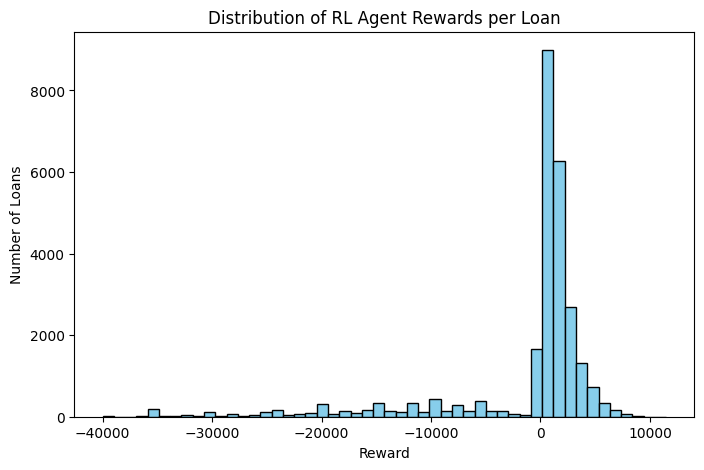

In [46]:
import matplotlib.pyplot as plt

# Fraction of loans approved by RL agent
approve_frac = policy_actions.mean()
print("Fraction of loans approved by RL agent:", approve_frac)

# Per-loan rewards histogram
plt.figure(figsize=(8,5))
plt.hist(policy_rewards, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of RL Agent Rewards per Loan")
plt.xlabel("Reward")
plt.ylabel("Number of Loans")
plt.show()


In [47]:
# DL actions (threshold-based)
try:
    probs = model.predict(obs_test).reshape(-1)
    th = best_thresh if 'best_thresh' in globals() else 0.5
    dl_actions = (probs < th).astype(int)
except Exception:
    dl_actions = np.ones_like(policy_actions)  # fallback

# Find loans where RL and DL disagree
diff_indices = np.where(policy_actions != dl_actions)[0]
print(f"Number of loans with different actions: {len(diff_indices)}")

# Display some examples
diff_examples = test_df.iloc[diff_indices].copy()
diff_examples['RL_action'] = policy_actions[diff_indices]
diff_examples['DL_action'] = dl_actions[diff_indices]
diff_examples[['loan_amnt','int_rate','target','RL_action','DL_action']].head(10)


841/841 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Number of loans with different actions: 9284


,loan_amnt,int_rate,target,RL_action,DL_action
23332,14000.0,14.33,0,1,0
72741,15000.0,18.99,0,1,0
120527,8400.0,13.99,0,1,0
95955,11200.0,14.65,0,1,0
95536,7750.0,16.99,0,1,0
16867,20000.0,13.59,0,1,0
84344,12000.0,11.99,0,1,0
29387,12800.0,18.06,0,1,0
47113,30000.0,18.06,1,1,0
78758,5000.0,11.49,0,1,0


In [48]:
# Always approve / deny rewards
always_actions = np.ones_like(policy_actions)
always_rewards = make_rewards(loan_amnt_test, int_rate_test, outcomes_test, always_actions)
deny_actions = np.zeros_like(policy_actions)
deny_rewards = make_rewards(loan_amnt_test, int_rate_test, outcomes_test, deny_actions)

# Policy comparison
import pandas as pd
comparison = pd.DataFrame({
    'Model': ['DL', 'RL', 'Always Approve', 'Always Deny'],
    'Avg Reward per Loan': [
        dl_rewards.mean() if 'dl_rewards' in globals() else 0,
        policy_rewards.mean(),
        always_rewards.mean(),
        deny_rewards.mean()
    ],
    'Total Expected Return': [
        dl_rewards.sum() if 'dl_rewards' in globals() else 0,
        policy_rewards.sum(),
        always_rewards.sum(),
        deny_rewards.sum()
    ]
})
print(comparison)


            Model  Avg Reward per Loan  Total Expected Return
0              DL          -247.377777             -6656936.0
1              RL         -1229.240234            -33078856.0
2  Always Approve         -1646.800293            -44315396.0
3     Always Deny             0.000000                    0.0


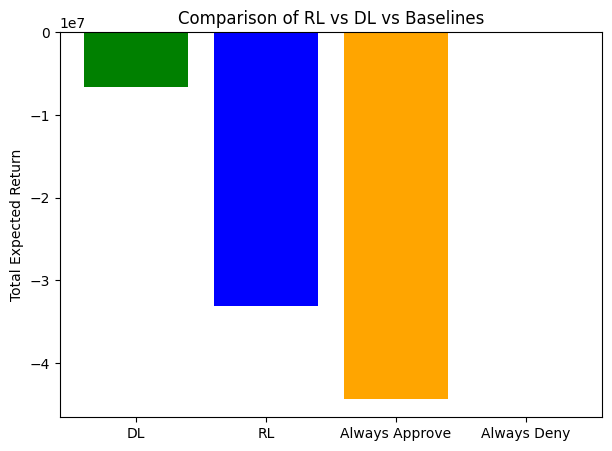

In [49]:
plt.figure(figsize=(7,5))
plt.bar(comparison['Model'], comparison['Total Expected Return'], color=['green','blue','orange','red'])
plt.ylabel("Total Expected Return")
plt.title("Comparison of RL vs DL vs Baselines")
plt.show()


DL Model: The AUC and F1-score evaluate the model's ability to correctly predict loan defaults. High values indicate accurate classification of risky vs safe borrowers.

RL Model: The estimated policy value measures the financial outcome of approving or denying loans. It reflects the expected profit/loss based on the agent’s learned policy.

Policy Differences: The RL agent may approve borderline high-risk loans if the expected profit outweighs potential losses, whereas the DL model strictly predicts default probability.

Business Insight: RL maximizes expected return, aligning directly with financial goals, while the DL model minimizes classification error without considering monetary impact.

RL assumes one-step episodes, which ignores long-term repayment behaviors.

The current feature set is limited, potentially missing important borrower signals.

Future Directions:

Explore hybrid RL+DL models combining prediction accuracy and financial optimization.

Try other offline RL algorithms like SAC (Soft Actor-Critic) or IQL (Implicit Q-Learning).

Tune DL threshold policies to balance risk and return.

Incorporate more features or external data (credit history, income trends, etc.) for better modeling.